In [1]:
# python stdlib
import os

# Scientific python libraries
import numpy as np
from scipy.constants import e, k, h

# Visualization
import matplotlib.pyplot as plt

DELTA = 0.250*1e-3*e
ROK_ENERGY_UNIT = (DELTA/0.166)
DELTA_UNIT = ROK_ENERGY_UNIT
V_RANGE = 0.605
FREQUENCY = 2*np.pi*368*1e6

In [2]:

def nrg_data_func(u, gfac, bfield):
    pathstr = f"NRG/U={u}-Zeeman/g={gfac}/B{bfield}/"
    op = np.genfromtxt(pathstr + "optical1.dat")
    n1 = np.genfromtxt(pathstr + "n1.dat")
    n2 = np.genfromtxt(pathstr + "n2.dat")
    return op, n1, n2

In [3]:

def gamma(g0, v0, T, N):
    numerator = np.exp(v0/(k*T)) + N
    denominator = np.exp(v0/(k*T)) - 1
    return g0*numerator/denominator


def etta(g0, v0, T, N):
    numerator = N*gamma(g0, v0, T, N)
    denominator = 4*k*T*((np.cosh(v0/(2*k*T)))**2)
    return numerator/denominator


def llambda(v0, T, N):
    numerator = np.exp(v0/(k*T)) + 1
    denominator = np.exp(v0/(k*T)) + N
    return numerator/denominator


def p0(smg, T, N):
    numerator = np.exp(smg/(k*T))
    denominator = np.exp(smg/(k*T)) + N
    return numerator/denominator


def q_capacitance(smg, T, N, dne, dng):
    return (e**2) * (p0(smg, T, N)*(dne - dng) - dne)


def tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ne - ng)*gamma(g0, smg, T, N)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator


def total_capacitance(g0, smg, dsmg, T, N, ne, ng, dne, dng, w):
    return tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w) + q_capacitance(smg, T, N, dne, dng)


def conductance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ne - ng)*(w**2)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator

In [4]:
def theoDelta(B):
    if B==220:
        return 0.00001
    else:
        return 0.166*np.sqrt(1 - (B/220)**2)

In [5]:

def analytical_data(gfac, Bfield, log_g0, global_parameters, v0):
    
    gap = theoDelta(Bfield)
    u, alpha, temp, log_n = global_parameters
    v0 = v0*alpha
    normunit = ROK_ENERGY_UNIT*1e3/e
    nu = (1 - v0/(u*normunit))
    
    n = 10**log_n
    g0 = 10**log_g0
    
    delta = DELTA_UNIT*np.float64(gap)
    
    if log_g0 == 0.0: g0 = 0.0
    w = FREQUENCY    
    
#     gammat_approx = gammat
    
    o1, n1, n2 = nrg_data_func(u,gfac,Bfield)
    
    s_mg = np.interp(nu, o1[:,0], o1[:, 1])*delta
    n_g  = np.interp(nu, n1[:,0], n1[:, 1])
    n_e  = np.interp(nu, n2[:,0], n2[:, 1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:, 1] - n1[:-1, 1]) / (-0.01*u)) / ROK_ENERGY_UNIT
    dn_e = np.interp(nu, n2[1:,0], (n2[1:, 1] - n2[:-1, 1]) / (-0.01*u)) / ROK_ENERGY_UNIT
    
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    
    ds_mg = np.interp(nu, o1[1:, 0], (o1[1:, 1] - o1[:-1, 1]) / (-0.01*u)) * delta / ROK_ENERGY_UNIT
    
    q_caps = alpha*alpha*q_capacitance(s_mg, temp, n, dn_e, dn_g)*1e15
    t_caps = alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, temp, n, n_e, n_g, w)*1e15
    t_caps = (t_caps + t_caps[::-1])/2
    c_total = q_caps + t_caps
    
    couduc = alpha*alpha*conductance(g0, s_mg, ds_mg, temp, n, n_e, n_g, w)*1e8
    couduc = (couduc + couduc[::-1])/2
    
    return q_caps, c_total, couduc

In [15]:
EXPERIMENTAL_PATH = 'G:/My Drive/GROWTH/Quantum computing/Majorana Project/Experimental data/Bx_data/Bx_closed/'
closebx = np.array([x[18:-4] for x in os.listdir(EXPERIMENTAL_PATH) if x[-1]=='v' and x[11]=='c'])
closebx = np.array(np.sort(np.int32(closebx)), dtype=np.unicode_)[:-1]
closebx[0] = '00'

def dataset_func_C(Bfield):
    return np.loadtxt(f"{EXPERIMENTAL_PATH}dataset_Bx_closed_{Bfield}.csv",
               skiprows = 1,
               delimiter = ',')[:, [0, 1, 5]]

In [17]:
def experimental_data(Bfield,symmetrize): #filter
    exp_v, exp_c, exp_r = dataset_func_C(Bfield).T
    exp_g = 1/exp_r
    exp_v = (exp_v - np.mean(exp_v))*1e3
    filter_bool = (exp_v < V_RANGE) * (-V_RANGE < exp_v) #+ True
    
    exp_c = exp_c[filter_bool]*1e15
    exp_g = exp_g[filter_bool]*1e8
    exp_v = exp_v[filter_bool]
    
    if symmetrize:
        exp_c = (exp_c + exp_c[::-1])/2
        exp_g = (exp_g + exp_g[::-1])/2
        
    return exp_v, exp_c, exp_g


In [18]:
#u3 vals
parampath = "G:\My Drive\GROWTH\Quantum computing\Majorana Project\parameter_NewData_delta-0.25_binmin_u3.csv"
PARAMETERS = np.loadtxt(parampath, skiprows = 1, delimiter = ',')
GLOBALS_U3 = PARAMETERS[0,3:]
GAMMAT_U3 = 0.01125

parampath = "G:\My Drive\GROWTH\Quantum computing\Majorana Project\parameter_NewData_delta-0.25_binmin_u4.csv"
PARAMETERS = np.loadtxt(parampath, skiprows = 1, delimiter = ',')
GLOBALS_U4 = PARAMETERS[0,3:]
GAMMAT_U4 = 0.0075


In [19]:
def plotfunc(fixed, gfac, Gamma_0, save=False):
    plt.close('all')
    fig, axes = plt.subplots(5,5,figsize=(25,20))
    axes = axes.flatten()
    u, alpha, temp, log_n = fixed
    parameter_string1 = f"$T = {temp*1000:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $U       = {u:.3f} * 1.506 meV $\
            $log_{{10}} N   = {log_n:.3f}$"
#     parameter_string2 = f"$log_{{10}} \Gamma_0 / Hz = {float(Gamma_0):.3f} $\
#             $\Gamma_t        = {gamma_t} $"
#     parameter_string2 = f"$\Gamma_t        = {gamma_t} $ (Fit parameter of B = 0 mT)"
    parameter_string2 = f"$g factor       = {gfac} $"

    fig.text(
        0.5, 0.95, parameter_string1, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=20)
    fig.text(
        0.5, 0.92, parameter_string2, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='lemonchiffon'), fontsize=20)
    
    closebx_vals = closebx[:-4]
    for ax, Bfieldvals in zip(axes,closebx):
        
        exp_v, exp_c, _ = experimental_data(Bfieldvals,0)
        Bfieldvals = int(Bfieldvals)
        q_caps = analytical_data(gfac, Bfieldvals, Gamma_0, fixed, exp_v)[0]
        ax.plot(exp_v, q_caps, label=f'Delta = {theoDelta(Bfieldvals):.4f} meV')
        ax.plot(exp_v, exp_c, label=f'B = {Bfieldvals} mT')
#         ax.legend(bbox_to_anchor=(0.1, -0.03, 0.8, .102),ncol=1)
        ax.legend(bbox_to_anchor=(0., 0.9, 1, .2),ncol=2)
#         ax.set_ylim(0,None)
    for idx in range(len(closebx_vals)-25,0,1):
        fig.delaxes(axes[idx])
    axes[0].set_ylabel(r'Total Capacitance, C (fF)',fontsize=15)
    axes[5].set_ylabel(r'Total Capacitance, C (fF)',fontsize=15)
    axes[10].set_ylabel(r'Total Capacitance, C (fF)',fontsize=15)
    axes[15].set_ylabel(r'Total Capacitance, C (fF)',fontsize=15)
    axes[20].set_ylabel(r'Total Capacitance, C (fF)',fontsize=15)
    axes[22].set_xlabel(r'$V_{P0} (mV) $',fontsize=15)

    if save:
        plt.savefig(f'DeltaDependence_v4u{u}.pdf')
#     axes

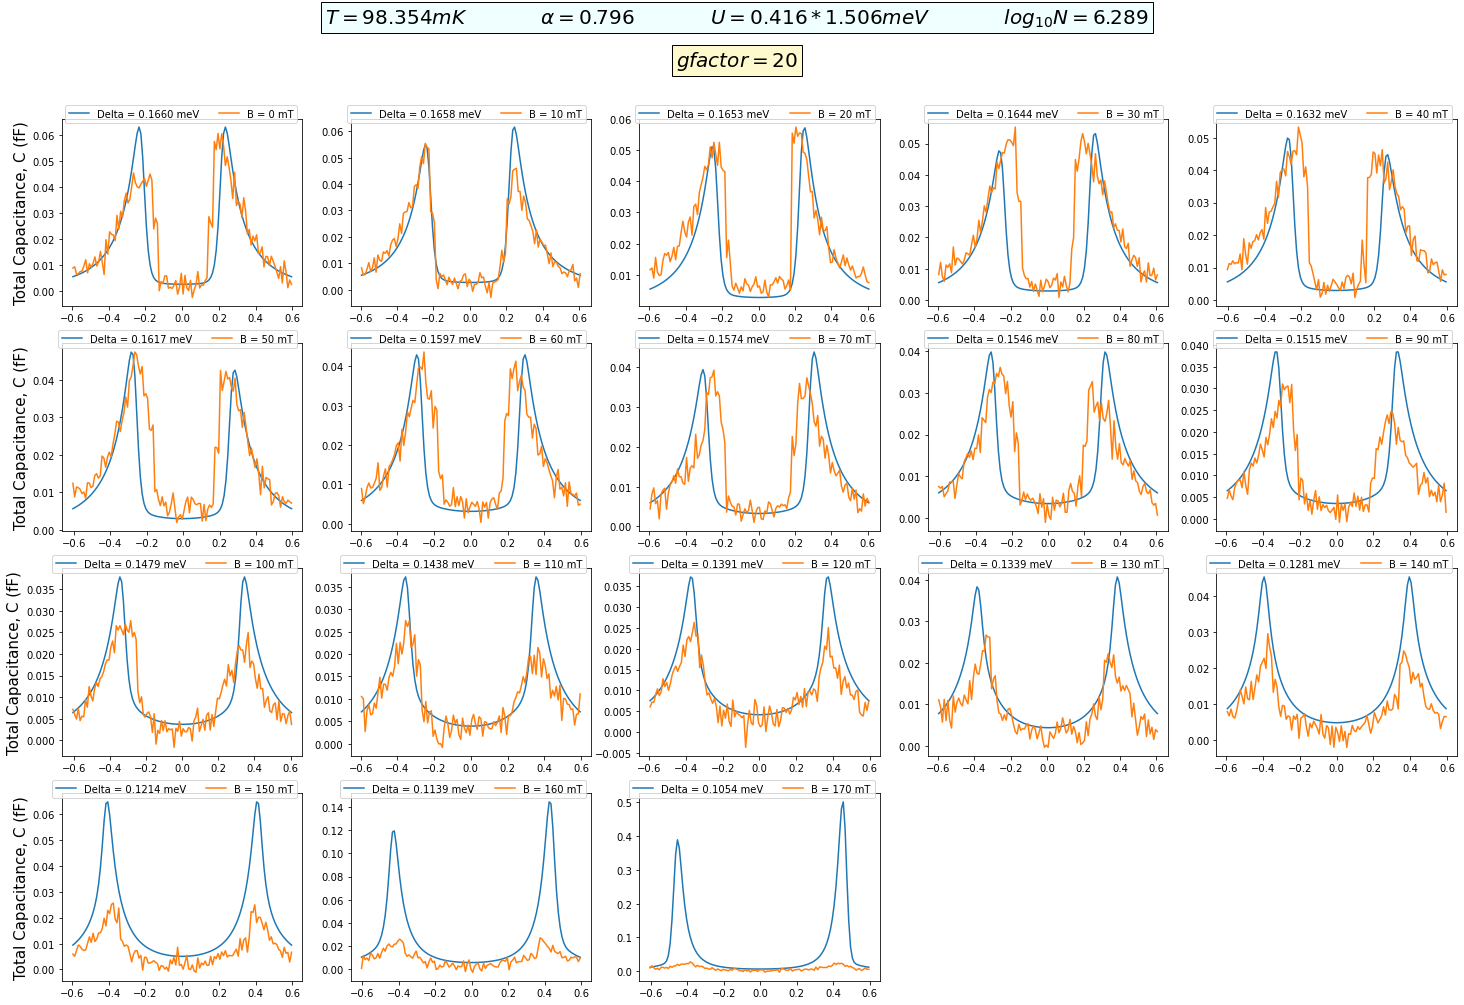

In [20]:
plotfunc(GLOBALS_U4, 20, 0.0,False)

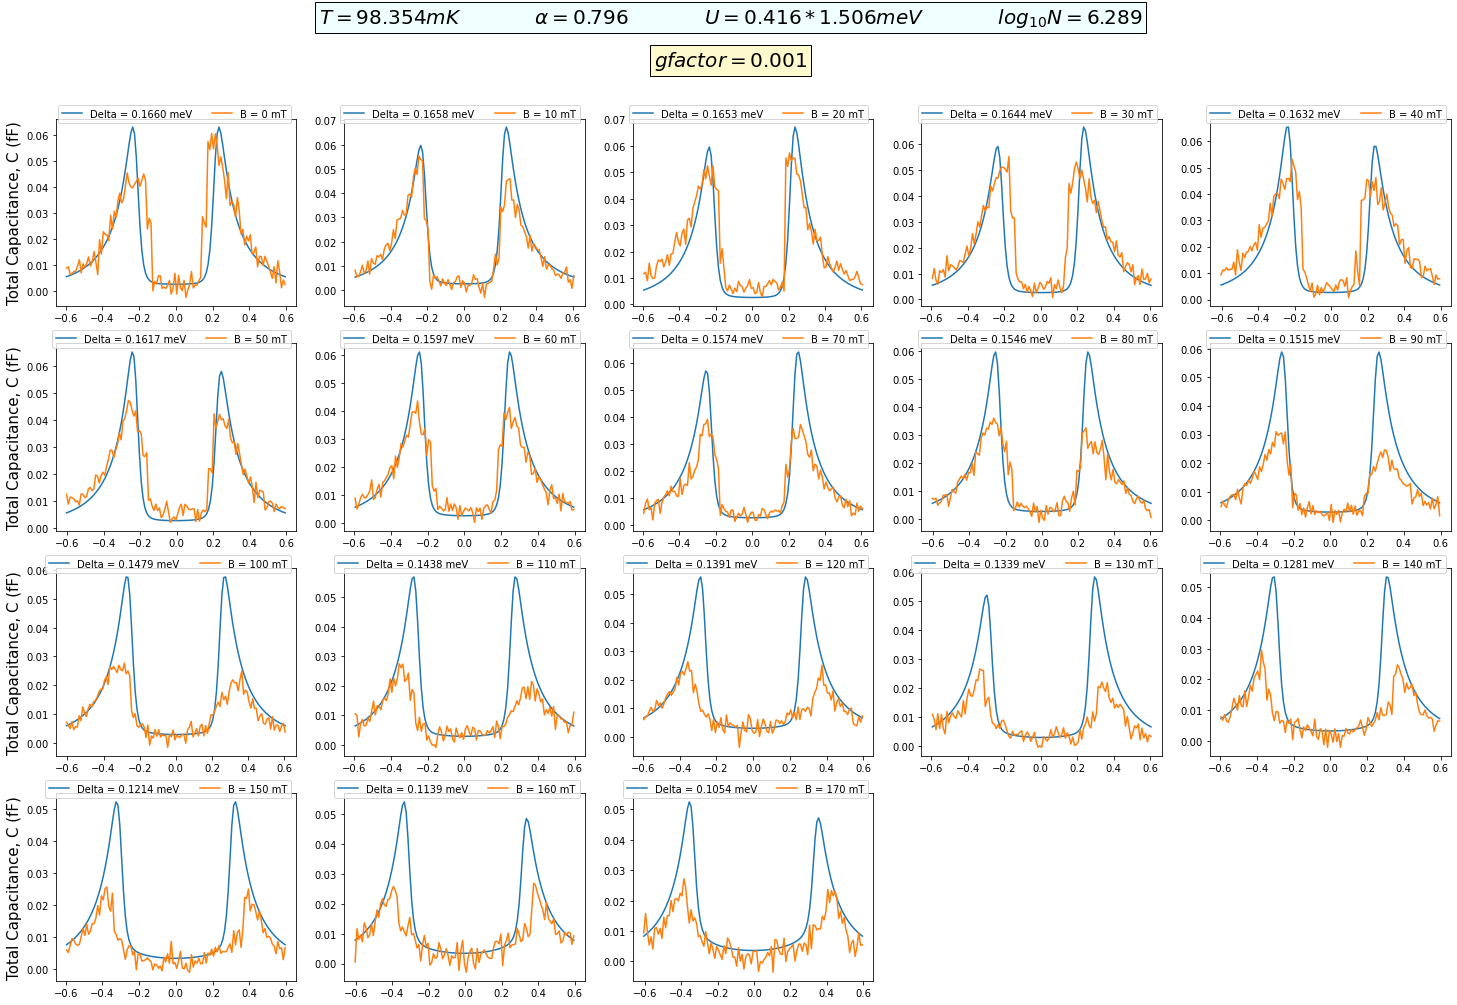

In [21]:
plotfunc(GLOBALS_U4, 0.001, 0.0,False)

In [41]:
def plotfunc(fixed, gfac_list, Gamma_0, save=False):
    plt.close('all')
    fig, axes = plt.subplots(5,5,figsize=(25,20))
    axes = axes.flatten()
    u, alpha, temp, log_n = fixed
    parameter_string1 = f"$T = {temp*1000:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $U       = {u:.3f} * 1.506 meV $\
            $log_{{10}} N   = {log_n:.3f}$"
#     parameter_string2 = f"$log_{{10}} \Gamma_0 / Hz = {float(Gamma_0):.3f} $\
#             $\Gamma_t        = {gamma_t} $"
    parameter_string2 = f"$\Gamma_t        = {GAMMAT_U4} $ (Fit parameter of B = 0 mT)"
#     parameter_string2 = f"$g factor       = {gfac} $"

    fig.text(
        0.5, 0.95, parameter_string1, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=20)
    fig.text(
        0.5, 0.92, parameter_string2, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='lemonchiffon'), fontsize=20)
    
    closebx_vals = closebx
    for ax, Bfieldvals in zip(axes,closebx):
        
        exp_v, exp_c, _ = experimental_data(Bfieldvals,0)
        Bfieldvals = int(Bfieldvals)
        for g_facor in gfac_list:
            q_caps = analytical_data(g_facor, Bfieldvals, Gamma_0, fixed, exp_v)[0]
            ax.plot(exp_v, q_caps, label=f'g factor = {g_facor}')
        ax.plot(exp_v, exp_c)
        ax.text(0.5,0.5,f'B = {Bfieldvals} mT',horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
#         ax.legend(bbox_to_anchor=(0.1, -0.03, 0.8, .102),ncol=1)
        ax.legend(bbox_to_anchor=(0., 0.9, 1, .2),ncol=2)
#         ax.set_ylim(0,None)
    for idx in range(len(closebx_vals)-25,0,1):
        fig.delaxes(axes[idx])
    axes[0].set_ylabel(r'Total Capacitance, C (fF)',fontsize=15)
    axes[5].set_ylabel(r'Total Capacitance, C (fF)',fontsize=15)
    axes[10].set_ylabel(r'Total Capacitance, C (fF)',fontsize=15)
    axes[15].set_ylabel(r'Total Capacitance, C (fF)',fontsize=15)
    axes[20].set_ylabel(r'Total Capacitance, C (fF)',fontsize=15)
    axes[22].set_xlabel(r'$V_{P0} (mV) $',fontsize=15)

    if save:
        plt.savefig(f'DeltaDependence_Zeeman_U{u}_g{gfac_list}.pdf')
#     axes

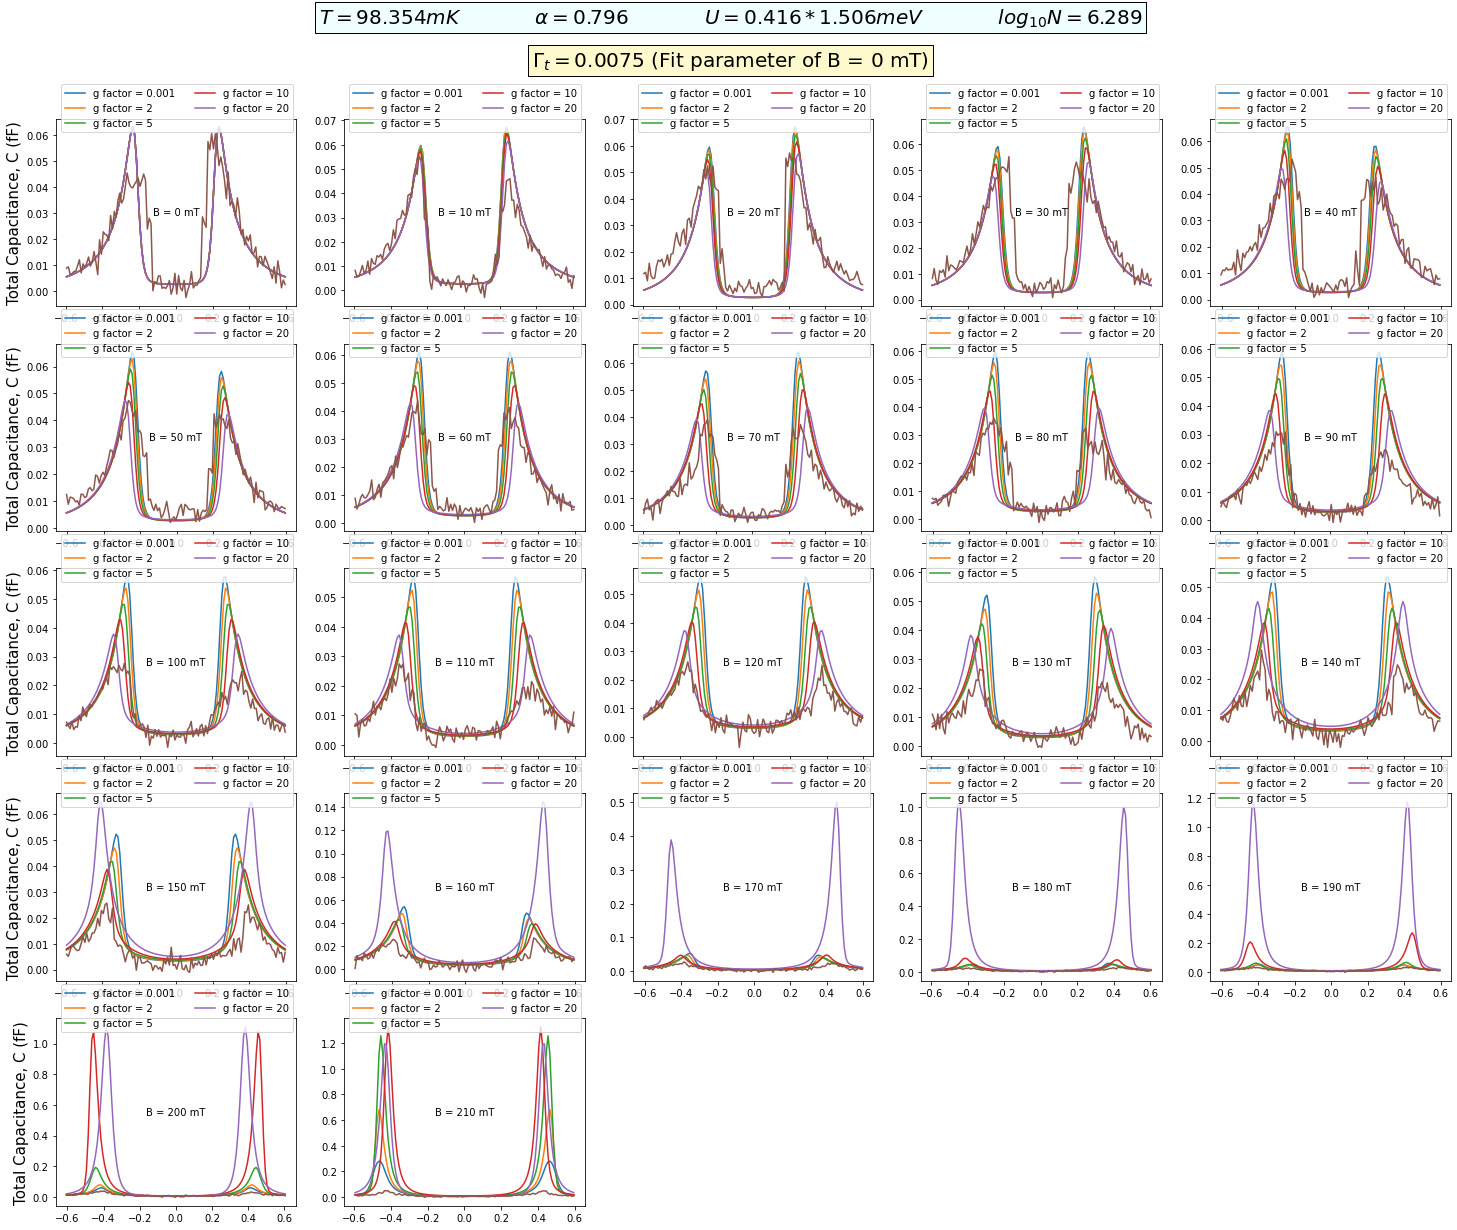

In [44]:
plotfunc(GLOBALS_U4, [0.001, 2, 5, 10, 20], 0.0,True)